# Data Loading


In [179]:
#importing necessery libraries for future analysis of the dataset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as plt
import seaborn as sns
import time
import numpy as np


## Function

### Transform files

These funtions below are used to read and transform data into readable df.

How To Use:

For transforming acceleromter and gyroscope data, please use `transform_data_acceleration(file, format)`, for:
- file: Pfad to file 
- format: json or csv

Example: 
```python
ubahn1_df = transform_data_acceleration('Data/Ubahn/Json/ubahn1.json','json')
ubahn2_df = transform_data_acceleration('Data/Ubahn/Json/ubahn2.json','json')
ubahn3_df = transform_data_acceleration('Data/Ubahn/Json/ubahn3.json','json')
```
For transforming location data, please use `transform_data_location(file, format, type)`, for:
- file: Pfad to file 
- format: json or csv
- type: Type of traffic (Ubahn, Bus, Auto, etc)

Example:
`ubahn1_df_loc = transform_data_location('Data/Ubahn/Json/ubahn1.json','json', 'ubahn')`

In [180]:
#Tranform accelerometer and gyroscope data to one dataframe
def transform_data_acceleration(file, format):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)  
         
    acce = df[df['sensor'] == 'Accelerometer']
    acce.reset_index(drop=True, inplace=True)   
    acce = acce.drop(columns =['sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    acce['Magnitude_acce'] = np.sqrt(acce["x"] ** 2 + acce["y"] ** 2 + acce["z"] ** 2)
    #acce in  positive

    gyro = df[df['sensor'] == 'Gyroscope']
    gyro.reset_index(drop=True, inplace=True)   
    gyro = gyro.drop(columns = ['sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    
    for df in [gyro, acce]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    #df_new = pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time')
    df_new = gyro.join(acce, lsuffix = '_gyro', rsuffix = '_acce', how = 'outer').interpolate()
   
    #df_new = pd.merge(pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time'), acce, suffixes=('', '_acce'), on='time')
    #df_new['Type'] = type
    
    return df_new

In [181]:
#Tranform location from file
def transform_data_location(file, format, type):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)   

    location = df[df['sensor'] == 'Location']
    location.reset_index(drop=True, inplace=True)
    location = location.drop(columns = ['sensor', 'z', 'y', 'x', 'relativeAltitude', 'pressure', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    #Speed using abs to positive
    
    
    location.index = pd.to_datetime(location['time'], unit = 'ns',errors='ignore')
    location.drop(columns=['time'], inplace=True)
    location['Type'] = type
    return location

### Compute features of the data based on 3 minutes temporal window.
These funtions below are used to find min, max, average, and standard deviation values for each 3 minutes time period.
How To Use:

After tranforming all dataframes using transform_data_acceleration, combine the dataframes into a single dataframe, for example:

`dfs = [ubahn1_df, ubahn2_df, ubahn3_df]`


Then using `combine_into_df(dfs, type)` function, for:
- dfs as defined above 
- type as type of transport 

Example:
`df = combine_into_df(dfs, 'ubahn')`


Result returns the following columns:
- Time
- Magnitude_acce_min
- Magnitude_acce_max
- Magnitude_acce_mean
- Magnitude_acce_std
- Type

In [182]:
#DONT USE: Cut data into windows of 3 minutes (only for one dataframe)
def cut_into_windows(df):
    #df = df.resample('3T').sum()
    # Create a new DataFrame with 'time' as the index
    pivot = pd.pivot_table(df, 
                           values=['Magnitude_acce'], #magnitue
                           index=['time'],
                           aggfunc={'Magnitude_acce': [np.max, np.mean]})
    #Resample the DataFrame to 3-minute intervals and calculate the sum
    #pivot = pivot.resample('3Min')
    return pivot

In [271]:
#Cut data into windows of 3 minutes and calculate min, max, mean and std
def create_feature_df(df, type):   
    min_values = df.resample('1Min').min(numeric_only=True)
    max_values = df.resample('1Min').max(numeric_only=True)
    mean_values = df.resample('1Min').mean(numeric_only=True)
    std_values = df.resample('1Min').std(numeric_only=True)
    #for df in [min_values, max_values, mean_values, std_values]:
     #   df.drop(columns= df.columns.difference(['Magnitude_acce']), inplace=True)
    feature_df = pd.merge(pd.merge(min_values, max_values, suffixes = ('_min', '_max'), on = 'time'), pd.merge(mean_values, std_values, suffixes = ('_mean', '_std'), on = 'time'), on = 'time')
    feature_df['Type'] = type

    return feature_df

In [272]:
#Combine 3-minutes windows data into one DataFrame (only in case there are more than one df)
def combine_into_df(dfs, type):
    combined_df = pd.concat([create_feature_df(df, type) for df in dfs])  # Apply cut_into_window to each DataFrame and concatenate them
    #combined_df.reset_index(drop=True, inplace=True)  # Reset the index of the combined DataFrame
    return combined_df

### Stream live data from app to website

In [177]:
import dash
from dash.dependencies import Output, Input
from dash import dcc, html, dcc
from datetime import datetime
import json
import plotly.graph_objs as go
from collections import deque
from flask import Flask, request

server = Flask(__name__)
app = dash.Dash(__name__, server=server)

MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

time = deque(maxlen=MAX_DATA_POINTS)
accel_x = deque(maxlen=MAX_DATA_POINTS)
accel_y = deque(maxlen=MAX_DATA_POINTS)
accel_z = deque(maxlen=MAX_DATA_POINTS)

app.layout = html.Div(
	[
		dcc.Markdown(
			children="""
			# Live Sensor Readings
			Streamed from Sensor Logger: tszheichoi.com/sensorlogger
		"""
		),
		dcc.Graph(id="live_graph"),
		dcc.Interval(id="counter", interval=UPDATE_FREQ_MS),
	]
)


@app.callback(Output("live_graph", "figure"), Input("counter", "n_intervals"))
def update_graph(_counter):
	data = [
		go.Scatter(x=list(time), y=list(d), name=name)
		for d, name in zip([accel_x, accel_y, accel_z], ["X", "Y", "Z"])
	]

	graph = {
		"data": data,
		"layout": go.Layout(
			{
				"xaxis": {"type": "date"},
				"yaxis": {"title": "Acceleration ms<sup>-2</sup>"},
			}
		),
	}
	if (
		len(time) > 0
	):  #  cannot adjust plot ranges until there is at least one data point
		graph["layout"]["xaxis"]["range"] = [min(time), max(time)]
		graph["layout"]["yaxis"]["range"] = [
			min(accel_x + accel_y + accel_z),
			max(accel_x + accel_y + accel_z),
		]

	return graph


@server.route("/data", methods=["POST"])
def data():  # listens to the data streamed from the sensor logger
	if str(request.method) == "POST":
		print(f'received data: {request.data}')
		data = json.loads(request.data)
		for d in data['payload']:
			if (
				d.get("name", None) == "accelerometer"
			):  #  modify to access different sensors
				ts = datetime.fromtimestamp(d["time"] / 1000000000)
				if len(time) == 0 or ts > time[-1]:
					time.append(ts)
					# modify the following based on which sensor is accessed, log the raw json for guidance
					accel_x.append(d["values"]["x"])
					accel_y.append(d["values"]["y"])
					accel_z.append(d["values"]["z"])
	return "success"


if __name__ == "__main__":
	app.run_server(port=8000, host="0.0.0.0")

ModuleNotFoundError: No module named 'dash'

### Code here:

In [273]:
#Read date for ubahn
ubahn1_df = transform_data_acceleration('Data/Ubahn/Json/ubahn1.json','json')
ubahn2_df = transform_data_acceleration('Data/Ubahn/Json/ubahn2.json','json')
ubahn3_df = transform_data_acceleration('Data/Ubahn/Json/ubahn3.json','json')
ubahn4_df = transform_data_acceleration('Data/Ubahn/Json/ubahn4.json','json')
ubahn5_df = transform_data_acceleration('Data/Ubahn/Json/ubahn5.json','json')
ubahn6_df = transform_data_acceleration('Data/Ubahn/Json/ubahn6.json','json')
ubahn7_df = transform_data_acceleration('Data/Ubahn/Json/ubahn7.json','json')

ubahn1_df_loc = transform_data_location('Data/Ubahn/Json/ubahn1.json','json', 'ubahn')

In [274]:
dfs = [ubahn1_df, ubahn2_df, ubahn3_df, ubahn4_df, ubahn5_df, ubahn6_df, ubahn7_df]
ubahn_df = combine_into_df(dfs, 'ubahn')
ubahn_df.head()

,seconds_elapsed_gyro_min,z_gyro_min,y_gyro_min,x_gyro_min,seconds_elapsed_acce_min,z_acce_min,y_acce_min,x_acce_min,Magnitude_acce_min,seconds_elapsed_gyro_max,...,seconds_elapsed_gyro_std,z_gyro_std,y_gyro_std,x_gyro_std,seconds_elapsed_acce_std,z_acce_std,y_acce_std,x_acce_std,Magnitude_acce_std,Type
time,,,,,,,,,,,,,,,,,,,,,
2023-05-24 06:22:00,0.061028,-4.469584,-3.980495,-2.605372,0.061028,-6.192753,-4.467911,-5.961443,0.006873,58.408036,...,16.847632,0.242763,0.272466,0.243138,16.847632,0.533630,0.406217,0.532307,0.674416,ubahn
2023-05-24 06:23:00,58.417967,-0.153267,-1.067077,-0.603562,58.417967,-3.126415,-1.559673,-2.170109,0.006435,118.412200,...,17.323136,0.040574,0.041049,0.068509,17.323136,0.338297,0.224130,0.232430,0.327992,ubahn
2023-05-24 06:24:00,118.422132,-0.556380,-1.151870,-1.420616,118.422132,-2.298995,-2.410858,-1.670463,0.006225,178.409793,...,17.321728,0.061830,0.120089,0.145741,17.321728,0.314884,0.215477,0.179626,0.318229,ubahn
2023-05-24 06:25:00,178.419724,-1.319973,-3.656870,-2.834619,178.419724,-5.703038,-4.931885,-3.319084,0.006647,238.405251,...,17.320643,0.144341,0.311813,0.287094,17.320643,0.580002,0.394580,0.368340,0.650728,ubahn
2023-05-24 06:26:00,238.415182,-3.566892,-4.851945,-4.105123,238.415182,-17.710230,-13.335277,-10.617250,0.012087,285.937006,...,13.722668,0.448374,0.638422,0.504145,13.722668,1.251087,0.947034,1.135419,1.661129,ubahn


In [275]:
#Read data for fahrrad
fahrrad1_df = pd.read_json('/Users/tramduong/Desktop/Python/GitHub/MaennerML/Data/Fahrrad/JSON/Fahrrad1new - Copy.json','json')
fahrrad2_df = pd.read_json('/Users/tramduong/Desktop/Python/GitHub/MaennerML/Data/Fahrrad/JSON/Fahrrad2new - Copy.json','json')

/var/folders/wm/p8nb38xx6kj3t8lkxdcj64qw0000gn/T/ipykernel_39164/1028919722.py:2: FutureWarning: Starting with pandas version 2.0 all arguments of read_json except for the argument 'path_or_buf' will be keyword-only.
  fahrrad1_df = pd.read_json('/Users/tramduong/Desktop/Python/GitHub/MaennerML/Data/Fahrrad/JSON/Fahrrad1new - Copy.json','json')
/var/folders/wm/p8nb38xx6kj3t8lkxdcj64qw0000gn/T/ipykernel_39164/1028919722.py:3: FutureWarning: Starting with pandas version 2.0 all arguments of read_json except for the argument 'path_or_buf' will be keyword-only.
  fahrrad2_df = pd.read_json('/Users/tramduong/Desktop/Python/GitHub/MaennerML/Data/Fahrrad/JSON/Fahrrad2new - Copy.json','json')


In [277]:
for df in [fahrrad1_df, fahrrad2_df]:
    df.rename_axis('time', axis='index', inplace=True)

In [278]:
dfs = [fahrrad1_df, fahrrad2_df]
fahrrad_df = combine_into_df(dfs, 'fahrrad')
fahrrad_df.head()

,seconds_elapsed_gyro_min,z_gyro_min,y_gyro_min,x_gyro_min,seconds_elapsed_acce_min,z_acce_min,y_acce_min,x_acce_min,Magnitude_acce_min,seconds_elapsed_gyro_max,...,seconds_elapsed_gyro_std,z_gyro_std,y_gyro_std,x_gyro_std,seconds_elapsed_acce_std,z_acce_std,y_acce_std,x_acce_std,Magnitude_acce_std,Type
time,,,,,,,,,,,,,,,,,,,,,
2023-05-19 09:51:00,0.048402,-3.866530,-3.950004,-3.293633,0.048402,-12.754095,-8.135932,-12.598273,0.146771,19.149298,...,5.518324,0.924970,0.726633,0.698612,5.518324,2.047792,1.479607,1.300290,1.587874,fahrrad
2023-05-19 09:52:00,19.159363,-7.773777,-4.484270,-3.908945,19.159363,-11.868351,-9.659114,-10.347145,0.062505,79.148484,...,17.321547,0.874443,0.771514,0.754970,17.321547,1.404308,1.409473,1.483398,1.510355,fahrrad
2023-05-19 09:53:00,79.158548,-1.018904,-2.069073,-2.130463,79.158548,-11.795681,-5.830164,-7.244730,0.108808,139.146947,...,17.321449,0.385110,0.605120,0.647228,17.321449,1.784375,1.137483,1.378458,1.336829,fahrrad
2023-05-19 09:54:00,139.157010,-1.109787,-2.051945,-2.351912,139.157010,-23.279099,-4.816469,-10.402971,0.099429,199.153606,...,17.323855,0.370952,0.751654,0.708853,17.323855,2.514409,1.172091,1.694032,1.620940,fahrrad
2023-05-19 09:55:00,199.163669,-1.057123,-1.791658,-2.138721,199.163669,-14.165509,-3.876797,-6.896581,0.026677,259.150352,...,17.321097,0.245212,0.475461,0.452057,17.321097,1.799449,0.791295,1.159417,1.528528,fahrrad


In [296]:
df_completed = pd.concat([ubahn_df, fahrrad_df])

In [280]:
df_completed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2023-05-24 06:22:00 to 2023-05-24 11:04:00
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   seconds_elapsed_gyro_min   73 non-null     float64
 1   z_gyro_min                 73 non-null     float64
 2   y_gyro_min                 73 non-null     float64
 3   x_gyro_min                 73 non-null     float64
 4   seconds_elapsed_acce_min   73 non-null     float64
 5   z_acce_min                 73 non-null     float64
 6   y_acce_min                 73 non-null     float64
 7   x_acce_min                 73 non-null     float64
 8   Magnitude_acce_min         73 non-null     float64
 9   seconds_elapsed_gyro_max   73 non-null     float64
 10  z_gyro_max                 73 non-null     float64
 11  y_gyro_max                 73 non-null     float64
 12  x_gyro_max                 73 non-null     float64
 13  seconds_elapse

## Data visualizations

In [ ]:
for df in [gy_ubahn1, acc_ubahn1]:
    df.index = pd.to_datetime(df['time'], unit = 'ns')

df = gy_ubahn1.join(acc_ubahn1, lsuffix = '_gyro', rsuffix = '_acce', how = 'outer').interpolate()

df.plot(figsize=(10,5))

In [36]:
#Tracking GPS 
import folium
import pandas as pd

coords = [(row.latitude, row.longitude) for _, row in loc_ubahn1.iterrows()]

my_map = folium.Map(location=[loc_ubahn1.latitude.mean(), loc_ubahn1.longitude.mean()], zoom_start=16)
folium.PolyLine(coords, color="blue", weight=5.0).add_to(my_map)
my_map

<AxesSubplot: xlabel='time', ylabel='speed'>

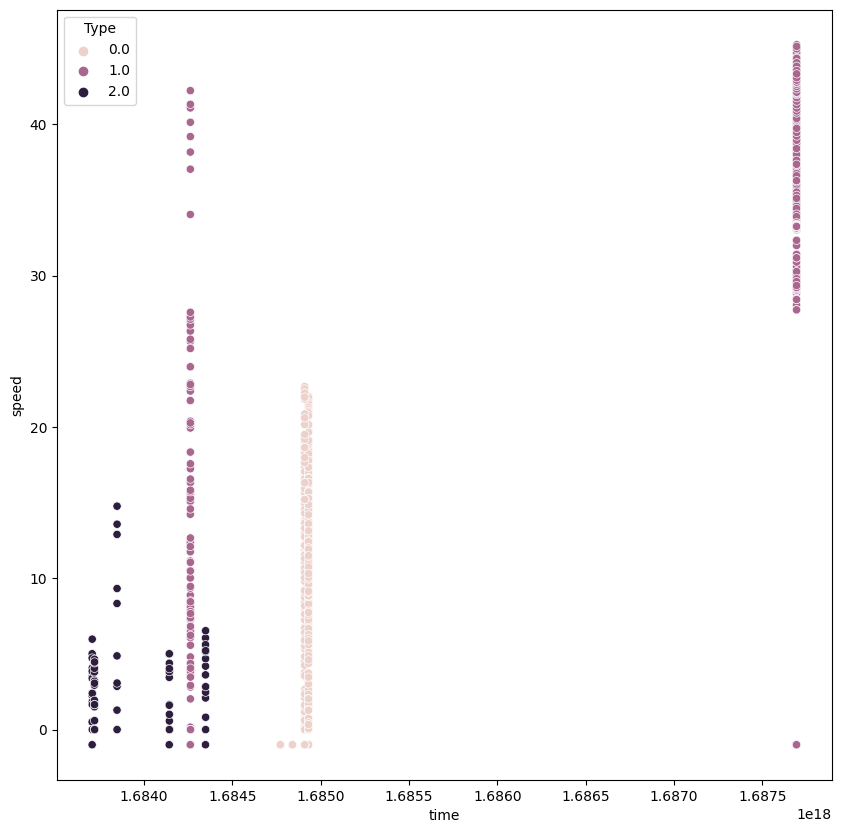

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Reminder: type_mapping = {'uBahn': '0', 'Auto': '1', 'Fahrrad': '2'}
plt.figure(figsize=(5,5))
sns.scatterplot(x='time', y='speed', hue='Type', data=location_df)

<AxesSubplot: >

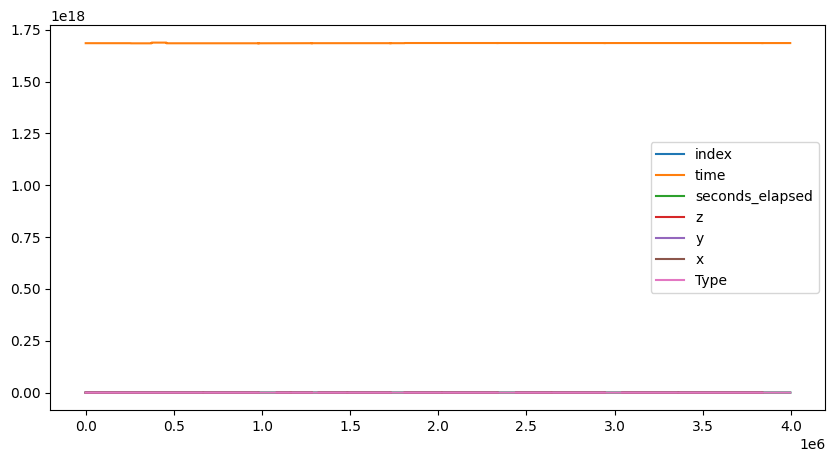

In [ ]:
accelerometer_df.plot(figsize=(10,5))

To read: [Fundamental Techniques of Feature Engineering for Machine Learning](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)



## Training the model

### Decision Tree

In [294]:
#importing decision tree model
from sklearn.metrics import mean_squared_error
import numpy as np 
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [297]:
#separating labels and predictors
x = df_completed.drop('Type',axis=1)
y = df_completed['Type'].values

#splitting train (75%) and test set (25%)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [285]:
#importing label encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [286]:
#transforming labels to numeric values
def transform_for_model(df):
    for i in range(len(df)):
        if df[i] == 'ubahn':
            df[i] = 0
        elif df[i] == 'auto':
            df[i] = 1
        elif df[i] == 'fahrrad':
            df[i] = 2
    return(df)

In [287]:
y_train = transform_for_model(y_train)
y_train

array([0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 2, 0, 2], dtype=object)

In [301]:
tree_reg = tree.DecisionTreeClassifier()
tree_reg.fit(x_train, y_train)
tree_predictions = tree_reg.predict(x_train)

"""
print("Type from Data Set:" )
print(y_train)
print("Type from Prediction: ")
print(tree_predictions)

#getting MSE and RMSE values
tree_mse=mean_squared_error(y_train,tree_predictions)
tree_rmse=np.sqrt(tree_mse)

print("Mean squared error: %.3f" % tree_mse)
print("Root mean squared error: %.3f" % tree_rmse)
"""

'\nprint("Type from Data Set:" )\nprint(y_train)\nprint("Type from Prediction: ")\nprint(tree_predictions)\n\n#getting MSE and RMSE values\ntree_mse=mean_squared_error(y_train,tree_predictions)\ntree_rmse=np.sqrt(tree_mse)\n\nprint("Mean squared error: %.3f" % tree_mse)\nprint("Root mean squared error: %.3f" % tree_rmse)\n'

In [302]:
from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   
clf_model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

In [304]:
y_predict = clf_model.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_test,y_predict)

0.8947368421052632

In [305]:
target = list(df_completed['Type'].unique())
feature_names = list(x.columns)

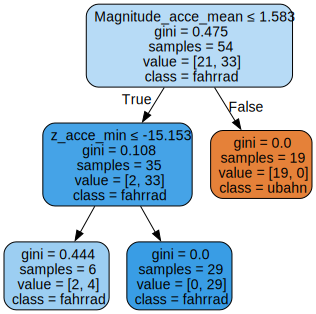

In [307]:
import graphviz
dot_data = tree.export_graphviz(clf_model,
                                out_file=None, 
                      feature_names=feature_names,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  

graph

In [289]:
from sklearn.model_selection import cross_val_score
#performing 10-fold validation
scores = cross_val_score(tree_reg, x_train, y_train, scoring = "neg_mean_squared_error",cv=20)

# skleanr's cross validation expect a utility function, so the greater the better. 
# That is why putting a negative sign
tree_rmse_scores=np.sqrt(-scores)
print("Scores:", tree_rmse_scores)
print("Mean: %.3f" % tree_rmse_scores.mean())
print("STD: %.3f" %  tree_rmse_scores.std())

Scores: [1.15470054 0.         0.         0.         1.15470054 0.
 1.15470054 0.         0.         0.         0.         0.
 0.         1.15470054 0.         0.         0.         0.
 0.         1.41421356]
Mean: 0.302
STD: 0.525


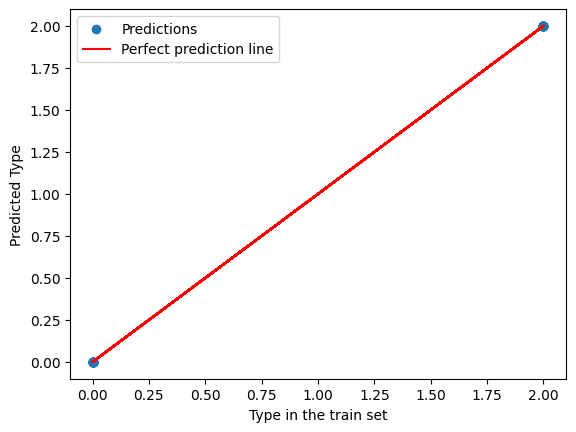

In [291]:
plt.scatter(y_train,tree_predictions, label='Predictions')
plt.plot(y_train,y_train,'r',label='Perfect prediction line')
plt.xlabel("Type in the train set")
plt.ylabel("Predicted Type")
plt.legend()

### Evaluate on the test set

In [263]:
x_test.head()

,Magnitude_acce_min,Magnitude_acce_max,Magnitude_acce_mean,Magnitude_acce_std
time,,,,
2023-05-24 11:00:00,0.013046,18.138574,1.852371,1.423293
2023-05-23 11:00:00,0.017529,11.569770,0.655850,1.041543
2023-05-24 06:12:00,0.070058,11.447549,1.234056,1.044807
2023-05-19 10:00:00,0.032654,29.621913,2.391766,1.501971
2023-05-24 12:24:00,0.002055,56.002174,0.298717,0.607824


In [266]:
#making predictions on the test set using the Decision tree model with pruning
x_test_prep = df_completed.transform(x_test)


SpecificationError: nested renamer is not supported

In [ ]:
#making predictions on the test set using the Decision tree model with pruning

final_predictions_tree = tree_reg.predict(x_test_prep)
print("Log_price from Data Set:" )
print(y_test)
print("Log_price from Prediction: ")
print(final_predictions_tree)
#getting mse and rmse values
final_mse_tree = mean_squared_error(y_test,final_predictions_tree)
final_rmse_tree = np.sqrt(final_mse_tree)

print("Mean squared error: %.3f" % final_mse_tree)
print("Root mean squared error: %.3f" % final_rmse_tree)

In [292]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#randomforest
rf= RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

#Test via Konfusionsmatrix
dm = confusion_matrix(y_test, y_pred)
print(dm)